# <center><span style="color:green">**Identify internet users.** **</span><span style="color:orange">Practice part</span>**
***    

#### <center>Simple EDA and feature engineering or how to make top200 without boosting, eli5/shap and other tricks

Итак, мы принимаем участие в соревновании на Kaggle под названием <b>"Catch Me If You Can"</b>.

Суть соревнования состоит в идентификации пользователя Alice по посейщенным сайтам, а именно по сессиям из 10 сайтов, длительность сессии не более 30 мин.
Участники, занявшие высокие места, получают дополнительные баллы в специализации.

In [48]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import scipy as sp
import eli5
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, ShuffleSplit, TimeSeriesSplit, learning_curve, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [2]:
# для сабмитов
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
# считываем train, test
## путь изменить на свой при необходимости
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')

# Сортировка по времени, т.к. данные привязаны ко времени
train_df = train_df.sort_values(by='time1')

In [4]:
sites = ['site%s' % i for i in range(1,11)]
times = ['time%s' % i for i in range(1, 11)]
#приводим время к datetime формату
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [5]:
#заполняем пропуски нулями
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [6]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [7]:
# Посмотрим на распределение отн. целевой переменной
train_df['target'].value_counts(normalize=False)

0    251264
1      2297
Name: target, dtype: int64

Выборка экстремально несбалансированная, оно и понятно, наша задача - поиск аномалий. 
Будем это учитывать в дальнейшем.

In [8]:
y_train = train_df['target']
df = pd.concat([train_df.drop('target', axis=1), test_df])
full_sites = df[sites]
idx_split = train_df.shape[0]

In [9]:
sites_flatten = full_sites.values.flatten()
sites_flatten

array([  56,   55,    0, ..., 1098, 1098, 1098])

In [10]:
full_sites_sparse = sp.sparse.csr_matrix(([1]*sites_flatten.shape[0], 
                                          sites_flatten, 
                                          range(0, sites_flatten.shape[0] + full_sites.shape[1],full_sites.shape[1])))[:, 1:]

In [11]:
# Отделяем по индексу
X_train = full_sites_sparse[:idx_split, :]
X_test = full_sites_sparse[idx_split:, :]

In [12]:
v = TfidfVectorizer(stop_words=[' ','  ',','], ngram_range=(1, 5), max_features=20000, max_df=0.5)

In [ ]:
full_sites_str = ["".join(str(sites)) for sites in df[sites].values]
full_sites_str

In [14]:
tfidf = v.fit_transform(full_sites_str)

In [15]:
tfidf

<336358x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 4478690 stored elements in Compressed Sparse Row format>

### Features

#### Фичи, основанные на сайтах
Можно извлечь и больше, а лучше использовать обратный маппинг сайтов, как Yorko делал в последнем кернеле. В том случае можно также сделать обобщения на случаи с www и без, посчитать доменные имена гораздо точнее и тд и тп

In [16]:
hosts = pd.read_pickle('site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # "меняем ключ и значение местами. Делать необязтельно, просто чуть удобней"

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # для соединения
df = pd.merge(df, hosts, how='left', on='site1')

#### Немножко "флагов"

In [17]:
df['big_site'] = df['len'].apply(lambda x: x > 5).astype(np.int8)
df['typical_site'] = df['len'].apply(lambda x: x == 3).astype(np.int8)
df['typical_domain'] = df['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

#### Фичи, основанные на длительности сессий

In [18]:
df['min'] = df[times].min(axis=1)
df['max'] = df[times].max(axis=1)
df['seconds'] = ((df['max'] - df['min']) / np.timedelta64(1, 'ms'))
df['minutes'] = ((df['max'] - df['min']) / np.timedelta64(1, 'm')).round(2)
df['short'] = df['minutes'].map(lambda x: x < 0.8).astype(np.int8)
df['long'] = df['minutes'].map(lambda x: x >= 0.8).astype(np.int8)
df.drop(['min','max'], inplace=True, axis=1)

#### Временные фичи

In [19]:
df['YearMonth'] = df['time1'].apply(lambda x:x.strftime('%Y%m')).astype('int64')
#df['Year'] = df['time1'].apply(lambda x:x.strftime('%Y')).astype('int64') --
#большая корреляция по Пирсону с YearMonth (очевидно), не зашло
df['Month'] = df.time1.dt.strftime('%m').astype('int64')
df['YearDay'] = df['time1'].apply(lambda x:x.strftime('%j')).astype('int64')
df['is_weekend'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)
df['wed'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in [2] else 0)
df['Hour'] = df.time1.apply(lambda x:x.strftime('%H')).astype('int64')
#df['Week'] = df['time1'].dt.strftime('%W').astype('int64') -- большая корреляция по Пирсону с YearDay, не зашло
df['Day_of_week'] = df['time1'].dt.strftime('%w').astype('int64')

#### Еще немножко "флагов"

In [20]:
df['Day'] = df.Hour.apply(lambda x:1 if x in range(12,19) else 0)
df['Eve'] = df.Hour.apply(lambda x:1 if x in range(19,24) else 0)
df['Night'] = df.Hour.apply(lambda x:1 if x in range(24,6) else 0) 
#несмотря на то, что график ничего не показывает и фьюч импортансы показывают нули, 
#присутствие флага дает прирост на LB. У некоторых людей прироста нет. Stranger things
df['Morning'] = df.Hour.apply(lambda x:1 if x in range(6,12) else 0)

In [21]:
df['is_summer'] = df['Month'].apply(lambda x: 1 if x in (6, 7, 8) else 0)

In [22]:
enc = OneHotEncoder()
hour = enc.fit_transform(df[['Hour']].as_matrix())
dayweek = enc.fit_transform(df[['Day_of_week']].as_matrix())
yday = enc.fit_transform(df[['YearDay']].as_matrix())
ym = enc.fit_transform(df[['YearMonth']].as_matrix())
lenn = enc.fit_transform(df[['len']].as_matrix())

In [23]:
features_to_scale = [
    'seconds',
]
df[features_to_scale] = StandardScaler().fit_transform(df[features_to_scale])

In [24]:
full_feat = sp.sparse.hstack([tfidf, 
                              dayweek,
                              hour,
                              yday, 
                              ym, 
                              lenn,
                              df.seconds.values.reshape(-1, 1), 
                              df.short.values.reshape(-1, 1),
                              df.long.values.reshape(-1, 1),
                              df.big_site.values.reshape(-1, 1),
                              df.typical_site.values.reshape(-1, 1),
                              df.typical_domain.values.reshape(-1, 1),
                              df.is_summer.values.reshape(-1, 1), 
                              df.wed.values.reshape(-1, 1),
                              df.is_weekend.values.reshape(-1, 1), 
                              df.Night.values.reshape(-1, 1), 
                              df.Day.values.reshape(-1, 1), 
                              df.Morning.values.reshape(-1, 1), 
                              df.Eve.values.reshape(-1, 1)]).tocsr()

In [25]:
Xfull_train = full_feat[:idx_split, :]
Xfull_test = full_feat[idx_split:, :]

In [26]:
# time awared CrossValidation
# поскольку у нас данные зависят от времени, стандартный кросс-фит просто перемешает всё в кучу и
# предсказания будут не точными. Для корректной кросс-валидации используем TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=10)

In [33]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [96]:
logit = LogisticRegression(solver='liblinear', C=3, penalty='l2', random_state=17)
#skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [28]:
%%time

cv_scores = cross_val_score(logit, Xfull_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

CPU times: user 108 ms, sys: 285 ms, total: 393 ms
Wall time: 15.7 s


In [29]:
cv_scores, cv_scores.mean()

(array([0.68384237, 0.91764399, 0.92235186, 0.96436976, 0.92522363,
        0.98607496, 0.86552679, 0.96986813, 0.91919592, 0.98777413]),
 0.9141871528502774)

In [32]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [101]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

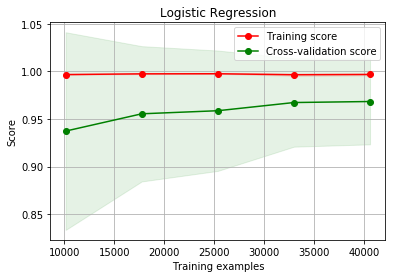

In [102]:
plot_learning_curve(logit, "Logistic Regression",
                    Xfull_train, y_train, cv=time_split,
                    train_sizes=np.linspace(.05, 0.2, 5))

Потом был перебор фич вручную, GridSearchCV для гиперпараметров векторайзера,

он же для гиперпараметров LR,

(params = {
    
    'C': np.logspace(-2, 2, 10),
    
    'penalty': ['l1','l2']
    
}),

переобученные xgboost-ы с hyperopt-ом и прочее. 

In [70]:
logit.fit(Xfull_train, y_train)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'submission__.csv') #0.95736

#### Побиты все baselines.

Поиск в Leaderboard Kaggle по нику 'Ivan Rubnenkov'

Лучший результат: <b>0.95758</b>. Место в Leaderboard <b>190</b> по состоянию на август 2019.

Ниже немного показательных графиков с хоть чуть-чуть нестандартными идеями
(т.е кроме того, что Alice активней днём, активней по выходным, менее активна летом, ночью никто не сидит)

In [ ]:
import plot

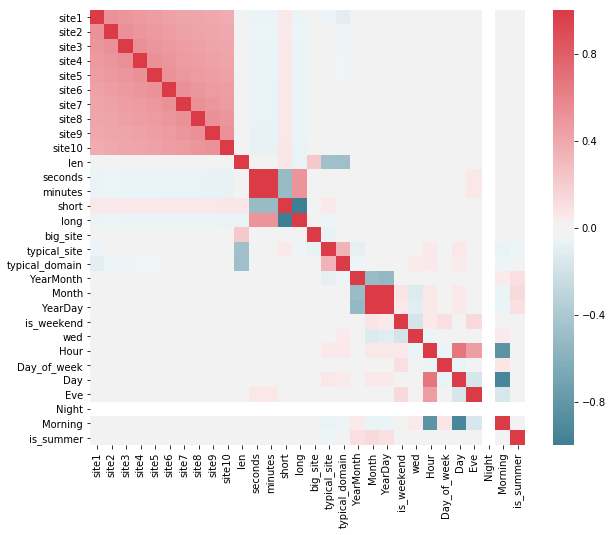

In [38]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [39]:
df.drop(['minutes','Month'], axis=1, inplace=True)

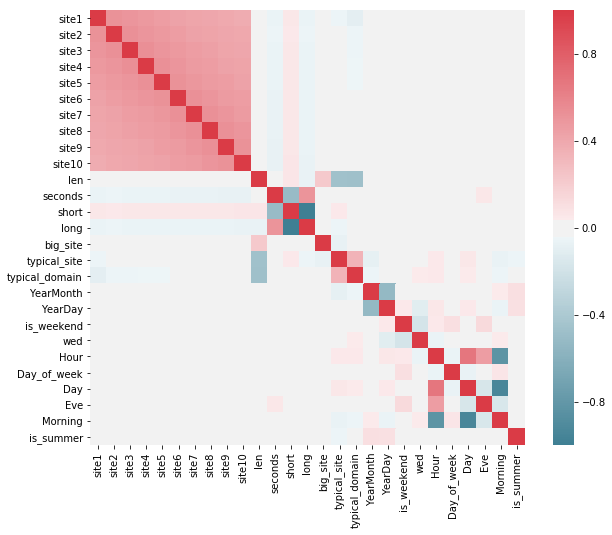

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.drop('Night',axis=1).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [53]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [65]:
start = df['YearMonth'][:idx_split].values
startday = df['YearDay'][:idx_split].values
y_tr = train_df['target'].astype('int').values

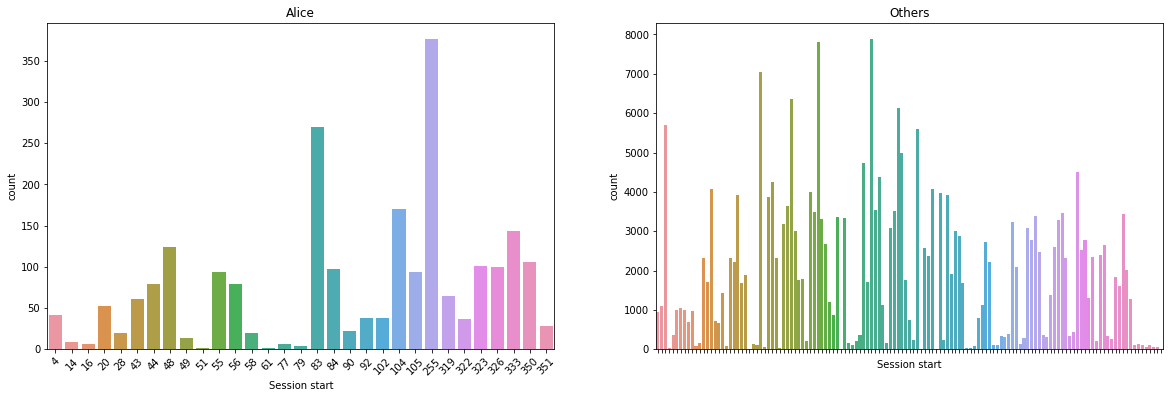

In [68]:
plt.subplots(1, 2, figsize = (20, 6)) 

plt.subplot(1, 2, 1)
chart = sns.countplot(startday[y_tr == 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Alice")
plt.xlabel('Session start')
          
plt.subplot(1, 2, 2)
chart = sns.countplot(startday[y_tr == 0])
chart.set(xticklabels=[])
plt.title('Others')
plt.xlabel('Session start');

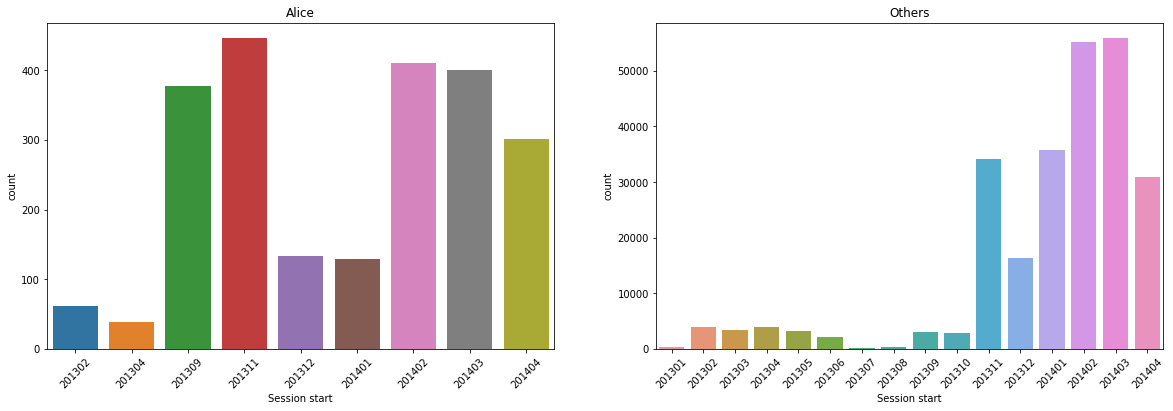

In [66]:
plt.subplots(1, 2, figsize = (20, 6)) 

plt.subplot(1, 2, 1)
chart = sns.countplot(start[y_tr == 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Alice")
plt.xlabel('Session start')
          
plt.subplot(1, 2, 2)
chart = sns.countplot(start[y_tr == 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Others')
plt.xlabel('Session start');

## Направления развития

Места для улучшения очень много, начиная от очевидной работы с feature importance и 
заканчивая такими мелочами, как взять милисекунды вместо секунд. Можно попробовать другие модели, <b>votingclassifier</b>, лучше настроить xgboost в конкретной (очень склонной к переобучению) задаче.
И однозначно можно добавить еще больше работы с признаками.

### Спасибо за просмотр и оценку коллегам с курса! :)